In [1]:
# import libraries
import os, sys, glob
import numpy as np
import matplotlib.pyplot as plt
import tables
sys.path.append('/home/ahinners/.local/lib/python3.11/site-packages')
import simweights

In [2]:
# Load in half the SIBYLL2.1 particle sims (The kernel might crash otherwise)
proton_filelist = glob.glob("/data/ana/CosmicRay/IceTop_level3/sim/IC86.2012/SIBYLL2.1/p/12360_v1s/h5files/*.h5")
helium_filelist = glob.glob('/data/ana/CosmicRay/IceTop_level3/sim/IC86.2012/SIBYLL2.1/He/12630_v1s/h5files/*.h5')

bigfilelist = proton_filelist + helium_filelist

In [3]:
# Load in the other hlaf of SIBYLL2.1 particle sims
oxygen_filelist = glob.glob('/data/ana/CosmicRay/IceTop_level3/sim/IC86.2012/SIBYLL2.1/O/12631_v1s/h5files/*.h5')
iron_filelist = glob.glob("/data/ana/CosmicRay/IceTop_level3/sim/IC86.2012/SIBYLL2.1/Fe/12362_v1s/h5files/*.h5")

bigfilelist += oxygen_filelist + iron_filelist

In [4]:
# Set the weighter for the data
weighter = None
for filename in bigfilelist:
    file_obj = tables.open_file(filename, "r")
    if weighter is None:
        weighter = simweights.IceTopWeighter(file_obj)
    else:
        weighter += simweights.IceTopWeighter(file_obj)

In [5]:
primary_energy = weighter.get_column("MCPrimary", "energy")
# (p, He, N, Al, Fe) version of this model.
fluxH = simweights.GaisserH4a_IT()

# Get the weights by passing the flux to the weighter
weights = weighter.get_weights(fluxH)

type = weighter.get_column('MCPrimary', 'type')

In [6]:
# Dictionary for weight data (practice in using dictionaries)
CUTS = {
    'proton': weighter.get_column("MCPrimary", "type")==2.21200000e+03,
    'helium' : weighter.get_column("MCPrimary", "type")==1.00002004e+09,
    'oxygen': weighter.get_column("MCPrimary", "type")==1.00008016e+09,
    'iron': weighter.get_column("MCPrimary", "type")==1.00026056e+09,
    'true': np.tile(True, len(primary_energy))
}
#FRAC = {
#   'true': 1,
#    'proton': np.log10(primary_energy[CUTS['proton']]) / primary_energy,
#    'helium': np.log10(primary_energy[CUTS['helium']]) / primary_energy,
#    'oxygen': np.log10(primary_energy[CUTS['oxygen']]) / primary_energy,
#    'iron': np.log10(primary_energy[CUTS['iron']]) /primary_energy
#}
Z = {
    'true': 0,
    'proton': 1,
    'helium': 2,
    'oxygen': 8,
    'iron': 26  
}
COLORS={
    'true' : 'black',
    'proton': 'red',
    'helium': 'orange',
    'oxygen': 'green',
    'iron': 'blue'
}
LABEL={
    'true' : 'Data',
    'proton': 'P',
    'helium': 'He',
    'oxygen': 'O',
    'iron': 'Fe'
}

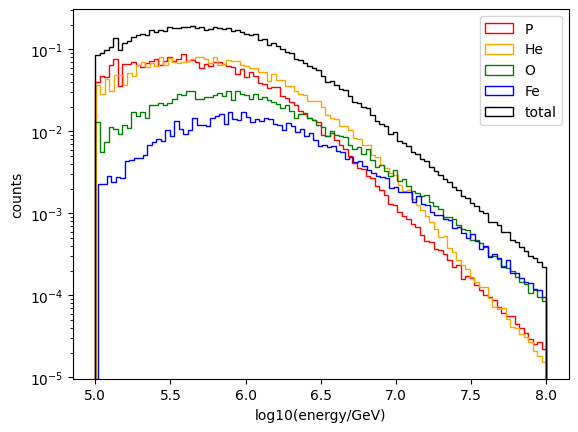

In [7]:
# Graph Log10 Energy vs Log 10 weighted counts

# Practice with dictionary
#fig, axs = plt.subplots(figsize=(13 * ncols, 8), ncols=ncols)
#for cut in CUTS:
#    axs.hist(np.log10(primary_energy)[CUTS[cut]], weights=weights[CUTS[cut]], label = LABEL[cut] ,**hist_args, color=COLORS[cut])
#    axs.set_xlabel('Energy')
#    axs.set_ylabel('Counts')
#plt.legend()

# Without dictionary
prot_cut = weighter.get_column('MCPrimary', 'type') == 2.21200000e+03
eli_cut = weighter.get_column('MCPrimary', 'type') == 1.00002004e+09
oxy_cut = weighter.get_column('MCPrimary', 'type') == 1.00008016e+09
iron_cut = weighter.get_column('MCPrimary', 'type') == 1.00026056e+09

(pwt, bins, patches1) = plt.hist(np.log10(primary_energy[prot_cut]),bins = 100, log = True, weights=weights[prot_cut], color = 'red',histtype = 'step', label ='P')
(hwt, bins, patches1) = plt.hist(np.log10(primary_energy[eli_cut]), bins = 100, log = True, weights=weights[eli_cut], color = 'orange',histtype = 'step', label = 'He') 
(owt, bins, patches1) = plt.hist(np.log10(primary_energy[oxy_cut]), bins = 100, log = True, weights=weights[oxy_cut], color = 'green', histtype = 'step', label = 'O')
(iwt, bins, patches1) = plt.hist(np.log10(primary_energy[iron_cut]), bins=100, log=True, weights=weights[iron_cut], color='blue',histtype='step',label='Fe')
tot = pwt + hwt + owt + iwt
plt.hist(np.log10(primary_energy), bins = 100, log = True, weights=weights ,color = 'black', histtype = 'step', label = 'total')

plt.xlabel('log10(energy/GeV)')
plt.ylabel('counts')
plt.legend()


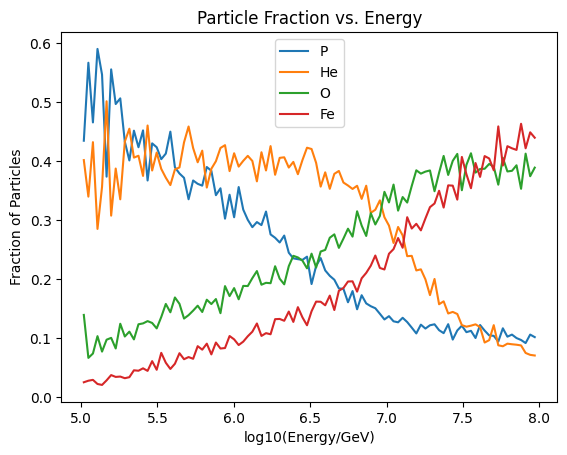

In [8]:
# attempts with dictionary
#tot = primary_energy[CUTS['true']]
#tot = primary_energy[CUTS['proton']] + primary_energy[CUTS['helium']] + primary_energy[CUTS['oxygen']] + primary_energy[CUTS['iron']]

#attempts without dictionary

pfrac= pwt / tot
hfrac = hwt / tot
ofrac = owt / tot
ifrac = iwt / tot
plt.plot(bins[:-1], pfrac, label = 'P')
plt.plot(bins[:-1], hfrac, label = 'He')
plt.plot(bins[:-1], ofrac, label = 'O')
plt.plot(bins[:-1], ifrac, label = 'Fe')

plt.xlabel('log10(Energy/GeV)')
plt.ylabel('Fraction of Particles')
plt.title('Particle Fraction vs. Energy')

plt.legend()

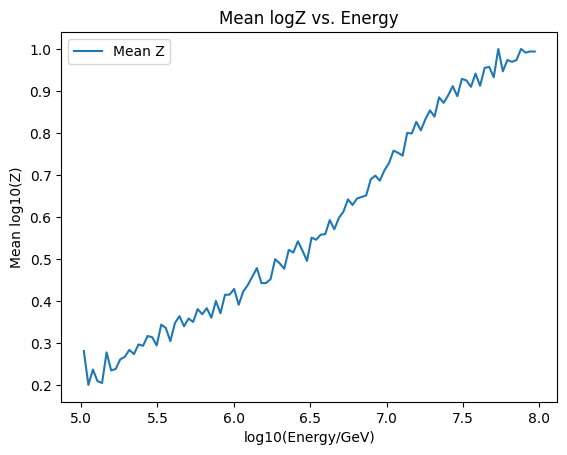

In [9]:
# Mean Atomic Charge (without dictionary)

PZ = pwt * np.log10(1)
HeZ = hwt * np.log10(2)
OZ = owt * np.log10(8)
FeZ = iwt * np.log10(26)
totZ = PZ + HeZ + OZ + FeZ
meanZ = totZ / tot
plt.plot(bins[:-1], meanZ, label = 'Mean Z')
plt.xlabel('log10(Energy/GeV)')
plt.ylabel('Mean log10(Z)')
plt.title('Mean logZ vs. Energy')
plt.legend()

In [10]:
# make a table of the overall percentage of particles

pro_cent = len(primary_energy[CUTS['proton']])/len(primary_energy)
eli_cent = len(primary_energy[CUTS['helium']])/len(primary_energy)
oxy_cent = len(primary_energy[CUTS['oxygen']])/len(primary_energy)
iro_cent = len(primary_energy[CUTS['iron']])/len(primary_energy)

cent_table = [['proton', round(pro_cent, 3)], 
              ['helium', round(eli_cent, 3)],
              ['oxygen', round(oxy_cent, 3)],
              ['iron', round(iro_cent, 3)]]

for row in cent_table:
    print(row)

['proton', 0.263]
['helium', 0.256]
['oxygen', 0.246]
['iron', 0.235]


In [16]:
fluxG = simweights.GlobalSplineFit_IT()

print(fluxG.pdgids)
print(fluxG.groups)

(<PDGCode.PPlus: 2212>, <PDGCode.He4Nucleus: 1000020040>, <PDGCode.O16Nucleus: 1000080160>, <PDGCode.Fe56Nucleus: 1000260560>)
((1, 1), (2, 2), (3, 10), (11, 28))
